# Unstructured Data Analytics HW2

Name: Dragon Xu

Andrew ID: runshenx

Collaborators (if none, say "none"; do *not* leave this blank): none

Reminder: you should not be sharing code.

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [6]:
import re
import string
import codecs

def make_word_list(path):
    # Read the file and store it in a string
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()
    # 1. Iterate over all the punctuation symbols and remove them from the text
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")
    # 2. Remove all the digits from the text
    text = re.sub(r'\S*\d\S*', '', corpus_text)
    # 3. Remove all the special characters (like @, #, or %) from the text
    text = re.sub(r'[^\w\s]', '', text)
    # 4. Convert to lower case and split the text into words
    text = text.lower().split()      
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [11]:
import os

def get_processed_files(path: str) -> list:
    # Get the list of files in the folder
    files = os.listdir(path)
    # Initialize an empty list to store the processed documents
    processed_files = []
    # Iterate through all the files in folder /data/enron
    for file in files:
        # Process the document if it is a text file
        if file.endswith('.txt'):
            # Get the full path of the file
            full_path = os.path.join(path, file)
            # Read the file and preprocess it
            processed_files.append(make_word_list(full_path))
    return processed_files

# Define the path to the folder containing the text files
path = r'data\enron'
# Get the list of preprocessed documents
processed_files = get_processed_files(path)
print(f"The size of processed files list is {len(processed_files)}")

The size of processed files list is 5171


### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer with min_df=50, stop_words="english", max_df=0.8
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=50, stop_words="english")
# Fit and transform the processed email documents into a sparse matrix
X = tfidf_vectorizer.fit_transform(processed_files)
print(f"The type of document matrix X is {type(X)}")
print(f"(# of documents, vocabulary size) = {X.shape}")
# Get the number of unique words in the vocabulary
vocabulary = tfidf_vectorizer.vocabulary_
print(f"Number of unique words in the vocabulary: {len(vocabulary)}")
print(vocabulary)

The type of document matrix X is <class 'scipy.sparse._csr.csr_matrix'>
(# of documents, vocabulary size) = (5171, 1680)
Number of unique words in the vocabulary: 1680
{'leadership': 792, 'development': 378, 'sally': 1310, 'timing': 1523, 'ask': 96, 'shall': 1360, 'receive': 1216, 'discussion': 398, 'listed': 817, 'update': 1577, 'team': 1491, 'information': 713, 'later': 785, 'week': 1634, 'learn': 795, 'energy': 463, 'operations': 1020, 'focus': 556, 'group': 618, 'ready': 1210, 'start': 1428, 'appropriate': 87, 'thank': 1506, 'time': 1521, 'today': 1525, 'questions': 1194, 'forwarded': 570, 'corp': 312, 'enron': 467, 'pm': 1097, 'susan': 1478, 'ect': 439, 'cindy': 231, 'hou': 666, 'robert': 1298, 'jones': 764, 'sheila': 1365, 'mary': 888, 'kim': 774, 'hope': 662, 'cc': 204, 'david': 344, 'good': 612, 'news': 973, 'regarding': 1231, 'ena': 459, 'help': 647, 've': 1601, 'performance': 1074, 'wilson': 1650, 'products': 1155, 'primary': 1135, 'programs': 1164, 'february': 534, 'purpose'

### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [32]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Initialize the GaussianMixture with 3 clusters
num_clusters = 3
gmm_3 = GaussianMixture(n_components=num_clusters, n_init=20, random_state=0)
# Convert the sparse matrix to a dense array
X_dense = np.array(X.todense())
# Fit the GaussianMixture on the document matrix X (converted to dense matrix)
gmm_clusters_3 = gmm_3.fit_predict(X_dense)
# Print the number of documents assigned to each cluster
for i in range(num_clusters):
    print(f"Number of documents in Cluster {i}: {sum(gmm_clusters_3 == i)}")

Number of documents in Cluster 0: 2532
Number of documents in Cluster 1: 857
Number of documents in Cluster 2: 1782


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [25]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

Spam wprds Indices: [238, 574, 1581]
Ham words Indices: [1283, 108, 904]


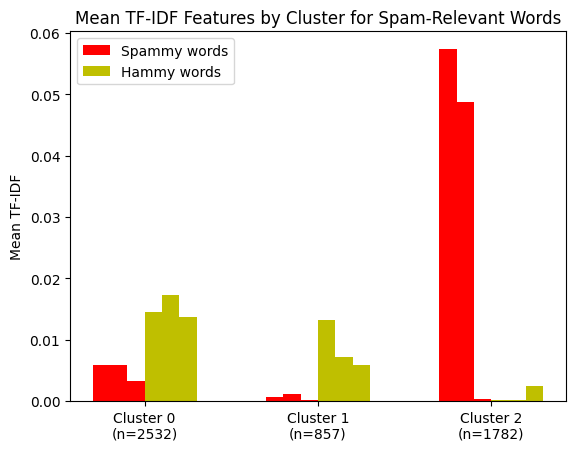

In [ ]:
# Define spammy words and hammy words
spam_words = ['click', 'free', 'urgent']
ham_words = ['review', 'attached', 'meeting']
# Get the indices of spammy words and hammy words in the vocabulary
spam_indices = [vocabulary[word] for word in spam_words if word in vocabulary]
ham_indices = [vocabulary[word] for word in ham_words if word in vocabulary]
print(f"Spam wprds Indices: {spam_indices}")
print(f"Ham words Indices: {ham_indices}")
# Plot the average TF-IDF features for your selected spammy words and hammy words for each cluster
plot_spam_words_by_cluster(X_dense, gmm_clusters_3, num_clusters, spam_indices, ham_indices)

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

1. For GMM with 3 clusters: 

    Cluster 0 has more ham words than spam words, it could be two cases: it is either a cluster of advanced spam emails that use less of traditional spam words that we selected, or a cluster of typical business emails that happen to have some spam words.

    Cluster 1 has few spam words features and most ham words, therefore it corresponds to typical business emails.

    Cluster 2 contains most of spam words and only a small percentage of ham words, therefore it appears to be spam emails cluster.




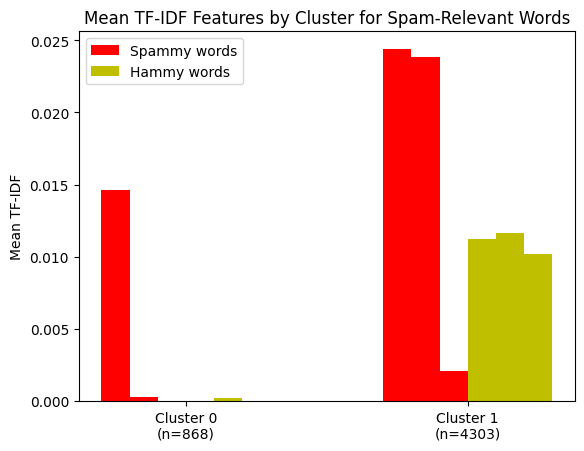

In [34]:
# Create another gmm_clusters with 2 clusters
num_clusters = 2
gmm_2 = GaussianMixture(n_components=num_clusters, n_init=20, random_state=0)
# Fit the GaussianMixture on the document matrix X (converted to dense matrix)
gmm_clusters_2 = gmm_2.fit_predict(X_dense)
plot_spam_words_by_cluster(X_dense, gmm_clusters_2, num_clusters, spam_indices, ham_indices)

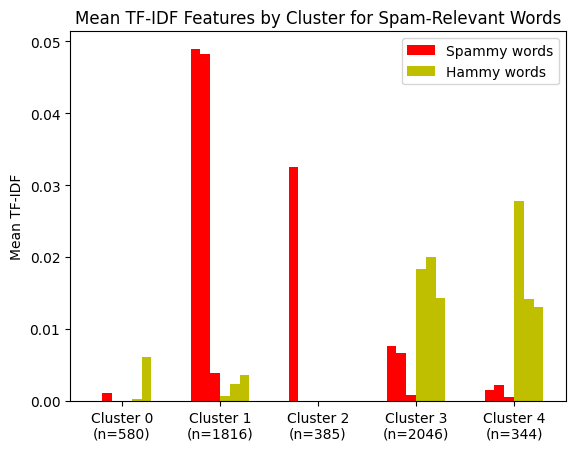

In [35]:
# Create another gmm_clusters with 5 clusters
num_clusters = 5
gmm_5 = GaussianMixture(n_components=num_clusters, n_init=20, random_state=0)
# Fit the GaussianMixture on the document matrix X (converted to dense matrix)
gmm_clusters_5 = gmm_5.fit_predict(X_dense)
plot_spam_words_by_cluster(X_dense, gmm_clusters_5, num_clusters, spam_indices, ham_indices)


2. For GMM with 2 clusters: 

    Although cluster 0 is obviously spam emails cluster, it is hard to interpret cluster 1 since it has more spam words features than ham words. It seems like the number of clusters constrains the interpretability of the model, because cluster 1 includes too many different cases.

3. For GMM with 5 clusters:

    Cluster 1 and 2 are very likely spam emails since the spam words features outweigh the ham words. Cluster 0 seems to be a corner case typical business emails that do not often contain either of the spam or ham words lists. Cluster 3 and 4 seems to be business emails, with only a small amount of spam words features.

In summary, GMM with 5 clusters seems to provide better interpretability than the other two choices. 

## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [51]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [52]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [53]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [57]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
# X is a numpy array
X = df_perms.values
del df # uncomment to free up RAM
del df_perms # uncomment to free up RAM
print(f"(# of apps/documents, # of permissions/words) = {X.shape}")

(# of apps/documents, # of permissions/words) = (180295, 173)


### Part C: Downweight "stopwords" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Initialize an instance of tfidf transformer
tfidf_transformer = TfidfTransformer()
# tfidf is a sparse matrix of the same shape as X but with scaled TF-IDF values.
# By using tfidf transformer, we reduce the weight of ubiquitous permissions like "INTERNET"
# and highlights more distinctive permissions that differentiate apps
tfidf = tfidf_transformer.fit_transform(X)
print(f"tfidf size: (# of documents, # of words) = {tfidf.shape}")

tfidf size: (# of documents, # of words) = (180295, 173)


### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Initialize the LDA model with 10 topics
num_topics = 10
# Print the top 10 words for each topic
n_top_words = 10

for i in range(num_topics):
    i += 2
    lda = LatentDirichletAllocation(n_components=i, random_state=0, max_iter=10, n_jobs=-1)
    # Fit the LDA model on the TF-IDF data
    lda.fit(tfidf)
    topic_word_distributions = np.array([row / row.sum() for row in lda.components_])
    print('-' * 80)
    print(f"\nNumber of topics: {i}")
    # lda.components_ is a matrix of shape (num_topics, # of words), where each entry is the weight of the word in the topic
    for topic_idx, topic in enumerate(lda.components_):
        print(f"\nTopic #{topic_idx + 1}:")
        # topic is an array of shape (# of words, ) containing the word weights
        # np.argsort returns the indices that would sort the array
        # [-n_top_words:] selects the last n_top_words indices from the array (largest n_top_words weights)
        # [::-1] reverses the order so that the largest weights come first
        top_words = topic.argsort()[-n_top_words:][::-1]
        print(", ".join([permission_columns[i] for i in top_words]))

--------------------------------------------------------------------------------

Number of topics: 2

Topic #1:
Your location : fine (GPS) location (D), Your location : coarse (network-based) location (D), Phone calls : read phone state and identity (D), System tools : automatically start at boot (S), Services that cost you money : directly call phone numbers (D), Storage : modify/delete USB storage contents modify/delete SD card contents (D), Hardware controls : take pictures and videos (D), Your personal information : read contact data (D), Network communication : full Internet access (D), System tools : retrieve running applications (D)

Topic #2:
Network communication : full Internet access (D), Network communication : view network state (S), Storage : modify/delete USB storage contents modify/delete SD card contents (D), System tools : prevent device from sleeping (D), Hardware controls : control vibrator (S), Network communication : view Wi-Fi state (S), System tools : set wallp

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [74]:
def print_top_features(model, feature_names, n_top_words=20):
    for topic_idx, topic_weights in enumerate(model.components_):
        print(f"\nTopic #{topic_idx + 1}:")
        
        # Get indices of the top n features for this topic
        top_feature_indices = topic_weights.argsort()[-n_top_words:][::-1]
        
        # Print the feature names and their weights
        for idx in top_feature_indices:
            print(f"{feature_names[idx]}: {topic_weights[idx]:.4f}")

lda = LatentDirichletAllocation(n_components=num_topics, random_state=0, max_iter=10, n_jobs=-1)
# Fit the LDA model on the TF-IDF data
lda.fit(tfidf)
# Print the top features for each topic
print_top_features(lda, permission_columns)




Topic #1:
Your location : coarse (network-based) location (D): 9180.6494
Your location : fine (GPS) location (D): 8726.5425
Network communication : full Internet access (D): 5508.5343
Network communication : view network state (S): 3668.4600
Phone calls : read phone state and identity (D): 2941.5574
Storage : modify/delete USB storage contents modify/delete SD card contents (D): 2342.3181
Services that cost you money : directly call phone numbers (D): 1892.0710
Network communication : view Wi-Fi state (S): 820.4519
Your personal information : read sensitive log data (D): 782.4855
System tools : send sticky broadcast (S): 483.3325
Hardware controls : test hardware (S): 62.0692
Default : access checkin properties (S): 48.8032
Hardware controls : control vibrator (S): 14.6847
Default : run in factory test mode (S): 7.8616
System tools : read/write to resources owned by diag (S): 5.5427
Default : permanently disable device (S): 3.8945
Default : reset system to factory defaults (S): 3.6685

Topic 1 seems to represent apps that are related to location service and communication service, such as google maps, or snapchat which has both communication function and location service to check the real time locations of friends.

Topic 3 seems to represent socials apps that reply on communication services, like facebook and instagram, since it contains features like "configured accounts", "contact data", "network communication", etc.

Topic 4 seems to represent system apps that manage personal information.

Topic 5 seems to represent system apps that manage the wallpapaers.

Topic 6 seems to represent system apps that manage files storage (for example "USB storage") and other utilities functions.

Topic 7 seems to represent camera and media apps.

Topic 8 seems to represent system apps that do WIFI connection and internet access.

Topic 10 seems to represent system apps that send SMS messages



### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [81]:
# Reference: the code here is adapted from the code in chatgpt

# Filter apps with >=100,000 ratings
threshold = 100000
high_rating_indices = np.where(app_ratings >= threshold)[0]
print(f"Number of apps with at least {threshold} ratings: {len(high_rating_indices)}")
# Compute topic probabilities for each app
tfidf_lda = lda.transform(tfidf)
print(f"Shape of topic probabilities: {tfidf_lda.shape}")
# Find the top 3 apps per topic
def get_top_apps_for_each_topic(tfidf_lda, app_names, high_rating_indices, n_top_apps=3):
    for topic_idx in range(tfidf_lda.shape[1]):
        # Extract probabilities for the current topic
        topic_probs = tfidf_lda[:, topic_idx]
        # Filter apps by rating threshold
        filtered_probs = [(i, topic_probs[i]) for i in high_rating_indices]
        # Sort by probability in descending order
        top_apps = sorted(filtered_probs, key=lambda x: x[1], reverse=True)[:n_top_apps]
        # Print the top apps for the current topic
        print(f"\nTopic #{topic_idx + 1}:")
        for app_idx, prob in top_apps:
            print(f"{app_names[app_idx]}: {prob:.4f}")

# Call the function
get_top_apps_for_each_topic(tfidf_lda, app_names, high_rating_indices)

Number of apps with at least 100000 ratings: 95
Shape of topic probabilities: (180295, 10)

Topic #1:
Dictionary.com: 0.7169
Air Control Lite: 0.7169
Paper Toss: 0.6935

Topic #2:
Bubble Blast 2: 0.6932
Mouse Trap: 0.6932
Drag Racing: 0.6932

Topic #3:
Angry Birds Seasons: 0.6247
Yoo Ninja! Free: 0.6247
Adobe Reader: 0.5500

Topic #4:
Lookout Security & Antivirus: 0.8569
Skype: 0.8489
WhatsApp Messenger: 0.8455

Topic #5:
Real BlackJack: 0.7164
Alchemy: 0.7155
Tank Hero: 0.7153

Topic #6:
My Country: 0.6962
Paradise Island: 0.6962
World Newspapers: 0.6962

Topic #7:
Brightest Flashlight Free???: 0.7625
Brightest Flashlight Free™: 0.7625
Tiny Flashlight + LED: 0.7497

Topic #8:
Slice It!: 0.7209
Racing Moto: 0.6878
Blast Monkeys: 0.6658

Topic #9:
TuneIn Radio: 0.7434
Restaurant Story???: 0.7273
Restaurant Story™: 0.7273

Topic #10:
Google Sky Map: 0.7063
chompSMS: 0.6317
Horoscope: 0.5811


### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

Shape of sampled data: (1000, 10)
Shape of t-SNE data: (1000, 2)
Shape of topic labels: (1000,)


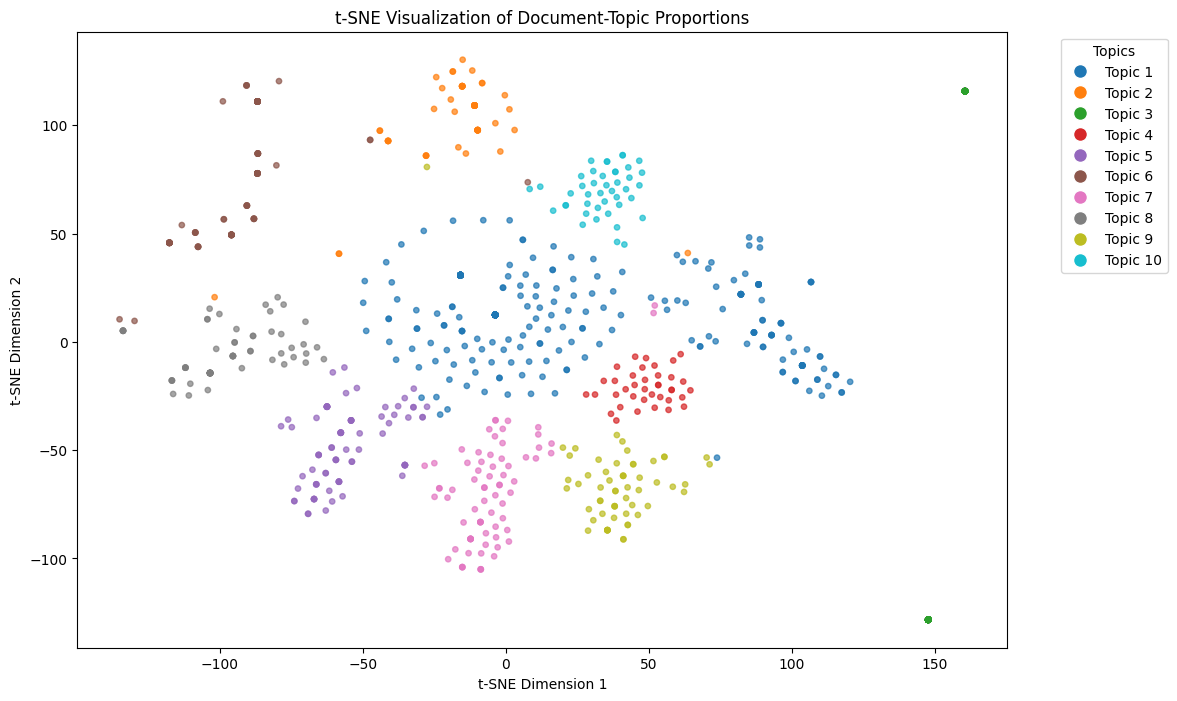

In [91]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
# Reference: the code here is adapted from the code in chatgpt

# Step 1: Sample the data (optional)
sample_size = 1000
indices = np.random.choice(tfidf_lda.shape[0], sample_size, replace=False)
sampled_data = tfidf_lda[indices]
print(f"Shape of sampled data: {sampled_data.shape}")

# Step 2: Fit t-SNE to the sampled data
tsne = TSNE(n_components=2, random_state=0, angle=0.99, init='pca', learning_rate=200)
tfidf_tsne = tsne.fit_transform(sampled_data)
print(f"Shape of t-SNE data: {tfidf_tsne.shape}")

# Step 3: Assign colors based on the most probable topic
# Calculates the index of the highest value in each row of tfidf_lda, the result contains the index of the topic with the highest probability for the 
topic_labels = np.argmax(sampled_data, axis=1)
print(f"Shape of topic labels: {topic_labels.shape}")
# Define a colorma. 
# The output is an array where each entry is an RGBA color corresponding to a document’s most probable topic.
colors = plt.cm.tab10(topic_labels / max(topic_labels))

# Step 4: Create a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=colors, s=15, alpha=0.7)

# Step 5: Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(i / max(topic_labels)), markersize=10) 
           for i in range(10)]
plt.legend(handles, [f"Topic {i+1}" for i in range(10)], title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 6: Add titles and labels
plt.title("t-SNE Visualization of Document-Topic Proportions")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://forms.gle/uPThbrNKEKi5jYpY7